# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [3]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [4]:
df1 = spark.read.option("multiLine", True).option('inferSchema', True).option('header', True).option("escape", "\"").csv('listings.csv').select('id', 'price', 'city', "neighbourhood", "review_scores_rating",  "property_type", "latitude", "longitude",  'number_of_reviews', 'first_review', 'last_review')
df2 = spark.read.option("multiLine", True).option('inferSchema', True).option('header', True).option("escape", "\"").csv('reviews.csv').select("listing_id", "comments", "date", "reviewer_id")

### Describe the data
List the features (schema) and sizes of the datasets.

In [5]:
df1.show()

+-------+---------+-----------------+--------------------+--------------------+------------------+--------+---------+-----------------+------------+-----------+
|     id|    price|             city|       neighbourhood|review_scores_rating|     property_type|latitude|longitude|number_of_reviews|first_review|last_review|
+-------+---------+-----------------+--------------------+--------------------+------------------+--------+---------+-----------------+------------+-----------+
| 145320|$1,272.00|        Stockholm|          SÃ¶dermalm|                  97|         Apartment|59.31364| 18.05256|               72|  2017-05-30| 2019-06-25|
| 155685|$3,209.00|        Stockholm|          SÃ¶dermalm|                  94|         Apartment|59.31535| 18.03277|               22|  2011-08-23| 2015-12-01|
| 220233|  $890.00|        Stockholm|            Norrmalm|                null|         Apartment|59.33948| 18.03551|                0|        null|       null|
| 220851|  $597.00|        Stockho

In [6]:
df1.printSchema()
df1.count()

root
 |-- id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- city: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- review_scores_rating: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- first_review: string (nullable = true)
 |-- last_review: string (nullable = true)



408202

In [7]:
df2.show()

+----------+--------------------+----------+-----------+
|listing_id|            comments|      date|reviewer_id|
+----------+--------------------+----------+-----------+
|    145320|Prima plek om Sto...|2017-05-30|  123386382|
|    145320|Cosy and clean fl...|2017-07-15|  123091743|
|    145320|The host canceled...|2017-07-20|      78004|
|    145320|Kim's place was o...|2017-07-31|  103178743|
|    145320|great spacious ap...|2017-08-22|    4023961|
|    145320|Kim is a very fri...|2017-09-02|  142869362|
|    145320|The apartment is ...|2017-09-09|   25194419|
|    145320|Nicely appointed,...|2017-09-13|   52056015|
|    145320|It was a pleasure...|2017-09-24|    3980456|
|    145320|Kim's place is si...|2017-10-09|   72139946|
|    145320|We absolutely lov...|2017-10-15|   23002655|
|    145320|Amazing place to ...|2017-11-10|    3451329|
|    145320|Very pleasant sta...|2017-11-13|  105945750|
|    145320|We had a wonderfu...|2017-11-19|     203826|
|    145320|Great location! C..

In [8]:
df2.printSchema()
df2.count()

root
 |-- listing_id: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)



29400608

Now, we will change the type of the attributes and delete the null values in preparation part.

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [9]:
import re

def filter_price (x):
    try:
        return float(re.sub(',', '', x[1:]))
    except:
        return "null"
    
filter_price_udf = f.udf(filter_price)

In [10]:
# Casting types and converting price column to float

df1 = df1.withColumn('Float Price', filter_price_udf(f.col('price')).cast(FloatType())).drop("price")

df1 = df1.withColumn("id", df1["id"].cast(IntegerType()))\
                .withColumn("review_scores_rating", df1["review_scores_rating"].cast(IntegerType()))\
                .withColumn("number_of_reviews", df1["number_of_reviews"].cast(IntegerType()))\
                .withColumn("latitude", df1["latitude"].cast(FloatType()))\
                .withColumn("longitude", df1["longitude"].cast(FloatType()))\
                .withColumn("first_review", f.unix_timestamp("first_review", "yyyy-MM-dd").cast(TimestampType()))\
                .withColumn("last_review", f.unix_timestamp("last_review", "yyyy-MM-dd").cast(TimestampType()))\
                .withColumn("first_review", f.to_date(f.col("first_review")))\
                .withColumn("last_review", f.to_date(f.col("last_review")))

df1.printSchema()

root
 |-- id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- review_scores_rating: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- first_review: date (nullable = true)
 |-- last_review: date (nullable = true)
 |-- Float Price: float (nullable = true)



In [11]:
df2 = df2.withColumnRenamed("listing_id", "id")

In [12]:
# Removing rows which contain null value
df1 = df1.filter(f.col("id").isNotNull())\
        .filter(f.col("city").isNotNull())\
        .filter(f.col("neighbourhood").isNotNull())\
        .filter(f.col("review_scores_rating").isNotNull())\
        .filter(f.col("property_type").isNotNull())\
        .filter(f.col("latitude").isNotNull())\
        .filter(f.col("longitude").isNotNull())\
        .filter(f.col("number_of_reviews").isNotNull())\
        .filter(f.col("first_review").isNotNull())\
        .filter(f.col("last_review").isNotNull())\
        .filter(f.col("Float Price").isNotNull())

print("Num rows: %s" %df1.count())

Num rows: 722185


In [13]:
df2 = df2.withColumn("id", df2["id"].cast(IntegerType()))\
         .withColumn("reviewer_id", df2["reviewer_id"].cast(IntegerType()))\
         .withColumn("date", f.unix_timestamp("date", "yyyy-MM-dd").cast(TimestampType()))\
         .withColumn("date", f.to_date(f.col("date")))

# Removing rows which contain null value
df2 = df2.filter(f.col("id").isNotNull())\
        .filter(f.col("comments").isNotNull())\
        .filter(f.col("reviewer_id").isNotNull())\
        .filter(f.col("date").isNotNull())

print("Num rows: %s" %df2.count())

Num rows: 32284171


In [14]:
df1.select(f.min("review_scores_rating"), f.max("review_scores_rating"), f.min("Float Price"), f.max("Float Price")).show()

+-------------------------+-------------------------+----------------+----------------+
|min(review_scores_rating)|max(review_scores_rating)|min(Float Price)|max(Float Price)|
+-------------------------+-------------------------+----------------+----------------+
|                       20|                      100|             0.0|       1000022.0|
+-------------------------+-------------------------+----------------+----------------+



Price = 0 Must be also wrong, Therefore we will delete these rows.

In [15]:
df1 = df1.filter(f.col("Float Price") > 0.0)
print("Num rows: " + str(df1.count()))

Num rows: 722076


In [16]:
df1.select(f.min("review_scores_rating"), f.max("review_scores_rating"), f.min("Float Price"), f.max("Float Price")).show()

+-------------------------+-------------------------+----------------+----------------+
|min(review_scores_rating)|max(review_scores_rating)|min(Float Price)|max(Float Price)|
+-------------------------+-------------------------+----------------+----------------+
|                       20|                      100|             1.0|       1000022.0|
+-------------------------+-------------------------+----------------+----------------+



We will create another dataframes which are called as "df3" and "df4" for the other analysis below. In that way, we will shrink the sizes of df1 and df2 as well. 

In [17]:
columns_1 = ('id', 'city', 'number_of_reviews', 'first_review', 'last_review',  'neighbourhood')
df4 = df1.select(*columns_1)

In [18]:
columns_2 = ('id', 'Float Price', 'city', "neighbourhood", "review_scores_rating",  "property_type", "latitude", "longitude")
df1 = df1.select(*columns_2)

In [19]:
columns_3 = ("id", "date", "reviewer_id")
df3 = df2.select(*columns_3)

In [20]:
columns_4 = ("id", "comments")
df2 = df2.select(*columns_4)

In [21]:
df1 = df1.cache()
df2 = df2.cache()
df3 = df3.cache()
df4 = df4.cache()

We have saved these smaller dataframe into the memory to execute our analysis faster.

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [22]:
result1 = df1.groupBy('city').agg(f.countDistinct('id').alias("Number of Listings"), f.countDistinct('neighbourhood').alias("Number of Neigbourhoods per City"))\
        .orderBy(f.col("Number of Listings").desc(), f.col("Number of Neigbourhoods per City").desc())
result1.show()

+-----------------+------------------+--------------------------------+
|             city|Number of Listings|Number of Neigbourhoods per City|
+-----------------+------------------+--------------------------------+
|            Paris|             48129|                              63|
|   Greater London|             33214|                             149|
|           London|             25354|                             148|
|      Los Angeles|             22279|                              95|
|           Berlin|             19705|                              93|
|             Roma|             18569|                              42|
|          Toronto|             17864|                             140|
|       KÃ¸benhavn|             17418|                              21|
|        Amsterdam|             16918|                              44|
|         New York|             16094|                              90|
|           Madrid|             15770|                          

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

City of Madrid is chosen.

In [23]:
df_madrid = df1.filter(f.col('city') == "Madrid")
df_madrid = df_madrid.cache()  # store small database in memory

In [24]:
df_b = df_madrid.drop('Float Price', 'city', 'review_scores_rating')
df_b = df_b.cache()

In [25]:
distinct_property = df_b.groupBy('neighbourhood').agg(f.countDistinct('id').alias("Number of Listings"), f.countDistinct('property_type').alias("Number of distinct Property Types"))

In [26]:
distinct_property = distinct_property.orderBy(f.col("Number of Listings").desc(), 'neighbourhood').show()

+------------------+------------------+---------------------------------+
|     neighbourhood|Number of Listings|Number of distinct Property Types|
+------------------+------------------+---------------------------------+
|            Centro|              4356|                               19|
|       Embajadores|              1018|                                9|
|               Sol|               531|                                9|
|         Salamanca|               509|                               14|
|         MalasaÃ±a|               508|                               12|
|           Palacio|               497|                                8|
|         La Latina|               489|                               10|
|         ChamberÃ­|               474|                                9|
|        Arganzuela|               462|                               10|
|          Justicia|               459|                               12|
|            Aluche|               452

In [27]:
column_list2 = ['neighbourhood', 'property_type']
w4 = Window.partitionBy([f.col(x) for x in column_list2]).orderBy(df_b.neighbourhood)
df_c = df_b.withColumn('Number of Listings',f.row_number().over(w4))
df_c = df_c.cache()
df_d = df_c.drop('id')
df_d = df_d.orderBy("neighbourhood",f.col("Number of Listings").desc())
pdf_1 = df_d.dropDuplicates(["neighbourhood", "property_type"]).toPandas()
pdf_1 = pdf_1.sort_values(['neighbourhood', 'Number of Listings'], ascending=[True, False])

Since the "Number of Listings" are needed to be computed, each "latitude" and "longitude" value isn't kept. Only the up to date values of "latitude" and "longitude" are kept in dataframe. Nevertheless, for each of the neigbourhood, and for each property type, number of listings are calculated. Table is as follows;

In [28]:
pdf_1 = pdf_1.reset_index(drop = True)
pdf_1.head(10)

,neighbourhood,property_type,latitude,longitude,Number of Listings
0,Acacias,Apartment,40.401058,-3.70377,49
1,Acacias,House,40.401031,-3.70107,2
2,Acacias,Serviced apartment,40.402401,-3.70114,2
3,Acacias,Guest suite,40.403641,-3.70282,2
4,Acacias,Loft,40.401310,-3.70408,1
5,Acacias,Condominium,40.399269,-3.70265,1
6,Acacias,Casa particular (Cuba),40.403450,-3.70483,1
7,Adelfas,Apartment,40.398048,-3.67107,25
8,Adelfas,Loft,40.401611,-3.66811,2
9,Adelfas,Other,40.400478,-3.67320,1


Now, new dataframe will be created. Number of Listings column is going to be removed to plot property type for neighbourhoods for each latitude and longtitude. 

In [29]:
df_e = df_c.drop('id' , 'Number of Listings')
pdf_2 = df_e.toPandas()
pdf_2 = pdf_2.sort_values(['neighbourhood', 'property_type'])
pdf_2 = pdf_2.reset_index(drop = True)
pdf_2.head(10)

,neighbourhood,property_type,latitude,longitude
0,Acacias,Apartment,40.403912,-3.70545
1,Acacias,Apartment,40.401112,-3.70053
2,Acacias,Apartment,40.401272,-3.70005
3,Acacias,Apartment,40.400299,-3.70338
4,Acacias,Apartment,40.404690,-3.71166
5,Acacias,Apartment,40.401379,-3.70087
6,Acacias,Apartment,40.405190,-3.70616
7,Acacias,Apartment,40.400459,-3.70832
8,Acacias,Apartment,40.400810,-3.70130
9,Acacias,Apartment,40.403671,-3.70481


We have choosen some of the neighbourhoods which are; 'Centro', 'Sol' and 'Usera' to plot.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 8)})
import matplotlib.dates as mdates

plt.figure(figsize = (20,10))
for label in np.unique(pdf_2["property_type"]):
    plt.scatter(pdf_2.latitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Centro')], 
                pdf_2.longitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Centro')], label=label)

plt.legend()
plt.show()

<Figure size 2000x1000 with 1 Axes>

Most of the property types in "Centro" neighbourhood is Apartment as it can be seen from above plot.

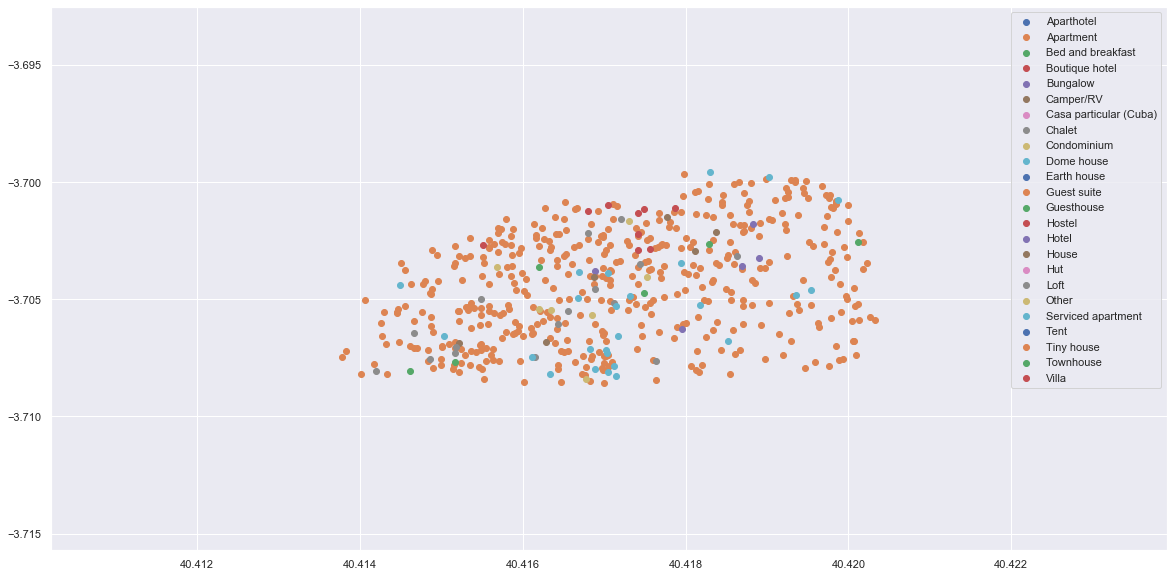

In [31]:
plt.figure(figsize = (20,10))
for label in np.unique(pdf_2["property_type"]):
    plt.scatter(pdf_2.latitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Sol')], 
                pdf_2.longitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Sol')], label=label)

plt.legend()
plt.show()

Most of the property types in "Sol" neighbourhood is Apartment as it can be seen from above plot.

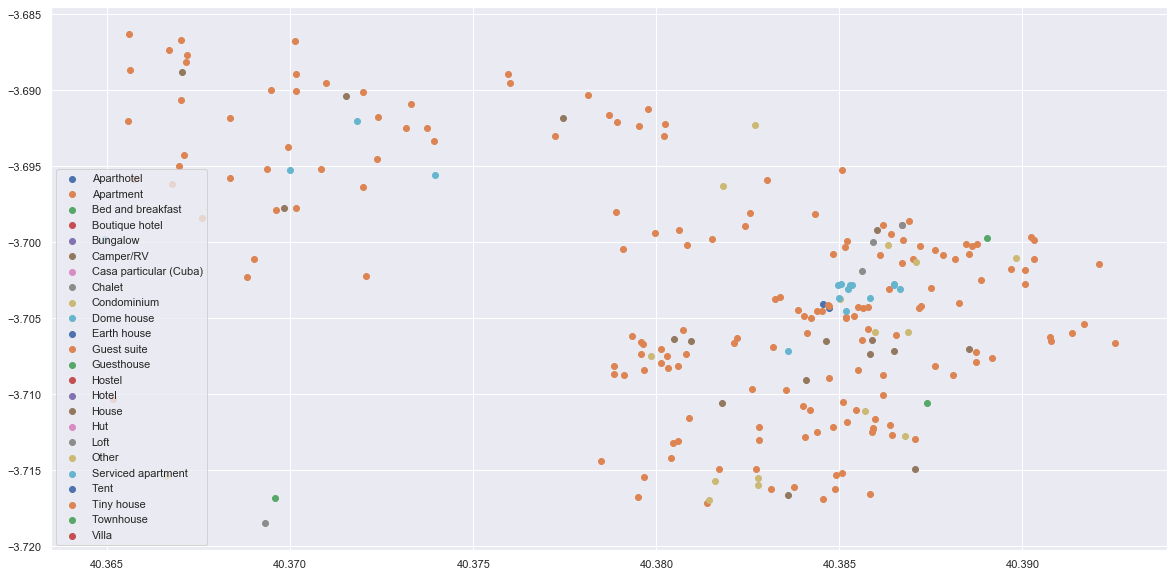

In [32]:
plt.figure(figsize = (20,10))
for label in np.unique(pdf_2["property_type"]):
    plt.scatter(pdf_2.latitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Usera')], 
                pdf_2.longitude[(pdf_2["property_type"]==label) & (pdf_2["neighbourhood"]=='Usera')], label=label)

plt.legend()
plt.show()

Most of the property types in "Usera" neighbourhood is Apartment as it can be seen from above plot.

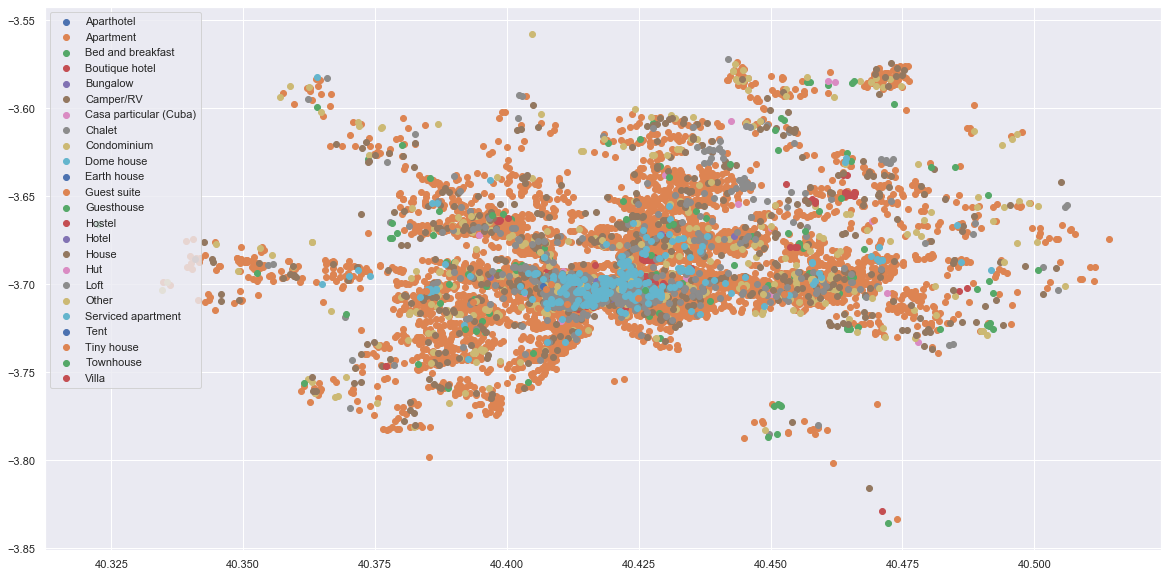

In [33]:
plt.figure(figsize = (20,10))
for label in np.unique(pdf_2["property_type"]):
    plt.scatter(pdf_2.latitude[pdf_2["property_type"]==label], 
                pdf_2.longitude[pdf_2["property_type"]==label], label=label)

plt.legend()
plt.show()

Plot above is the whole neighbourhoods in the city of madrid. Most of property type is Apartment (orange dots) in the city of Madrid.

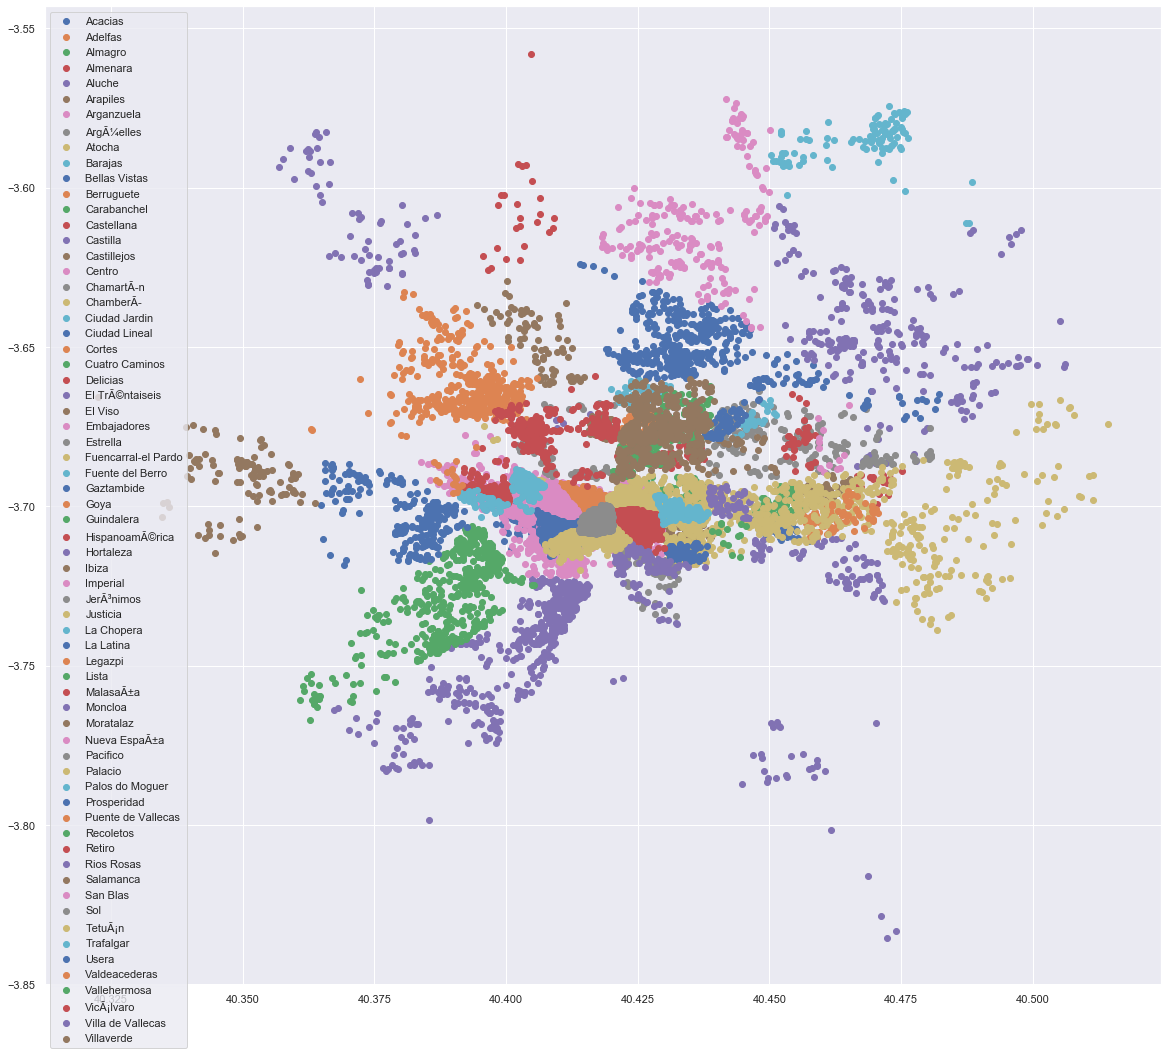

In [34]:
plt.figure(figsize = (20,18))
for label in np.unique(pdf_2["neighbourhood"]):
    plt.scatter(pdf_2.latitude[pdf_2["neighbourhood"]==label], 
                pdf_2.longitude[pdf_2["neighbourhood"]==label], label=label)

plt.legend()
plt.show()

Above plot is neighbourhood in the city of Madrid. Each color represents a different neighbourhood. But some of the colors are mixed.

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [35]:
df_madrid.select(f.max("Float Price").alias('Maximum of Listing Price'), f.min("Float Price").alias("Minumum of Listing Price"), 
                 f.avg("Float Price").alias('Average of Listing Price')).show()

+------------------------+------------------------+------------------------+
|Maximum of Listing Price|Minumum of Listing Price|Average of Listing Price|
+------------------------+------------------------+------------------------+
|                  9999.0|                     8.0|       97.12739378566899|
+------------------------+------------------------+------------------------+



Compute and visualize the distribution of listing prices in your city.

In [36]:
just_price = df_madrid.select('Float Price').toPandas()
just_p = pd.DataFrame(list(just_price['Float Price']), columns=['Price'])
just_p.Price = just_p.Price.astype(int)
just_p_v = just_p.values.flatten()

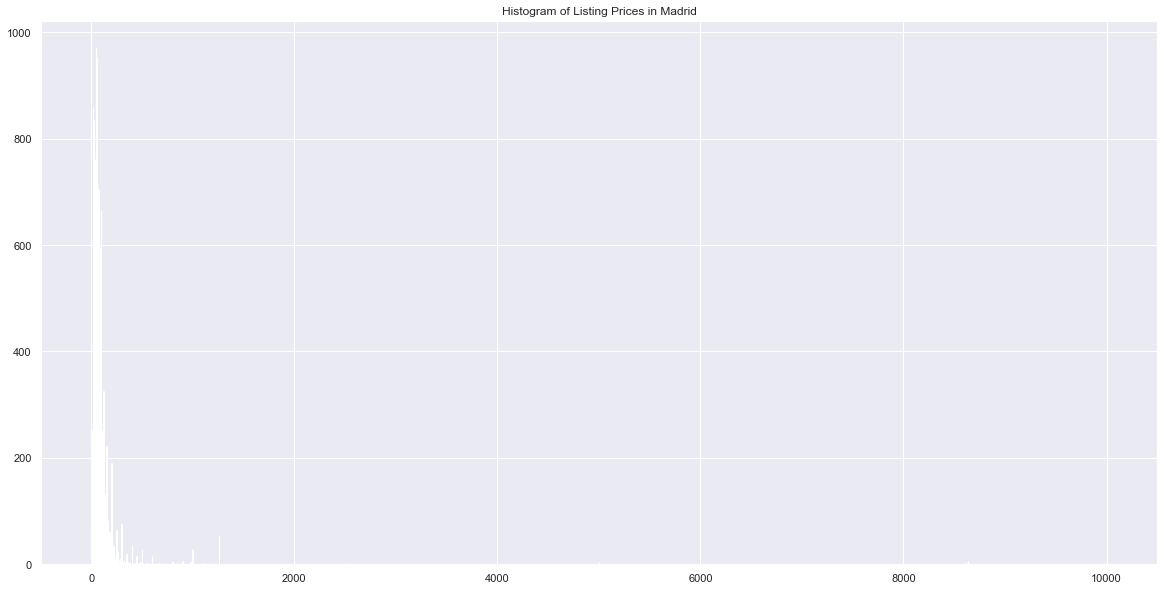

In [72]:
plt.figure(figsize=(20,10))
plt.hist(just_p_v, bins = 'auto', color="b")
plt.title("Histogram of Listing Prices in Madrid")
plt.show()

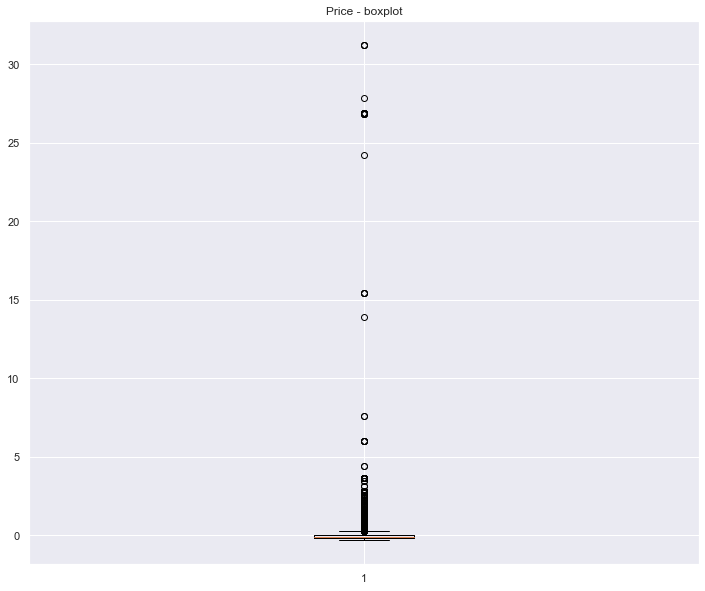

In [38]:
from scipy.stats import zscore
zscored_data = zscore(just_p_v, ddof = 1)
plt.figure(figsize=(12,10))
plt.boxplot(zscored_data)
plt.title('Price - boxplot')
plt.show()

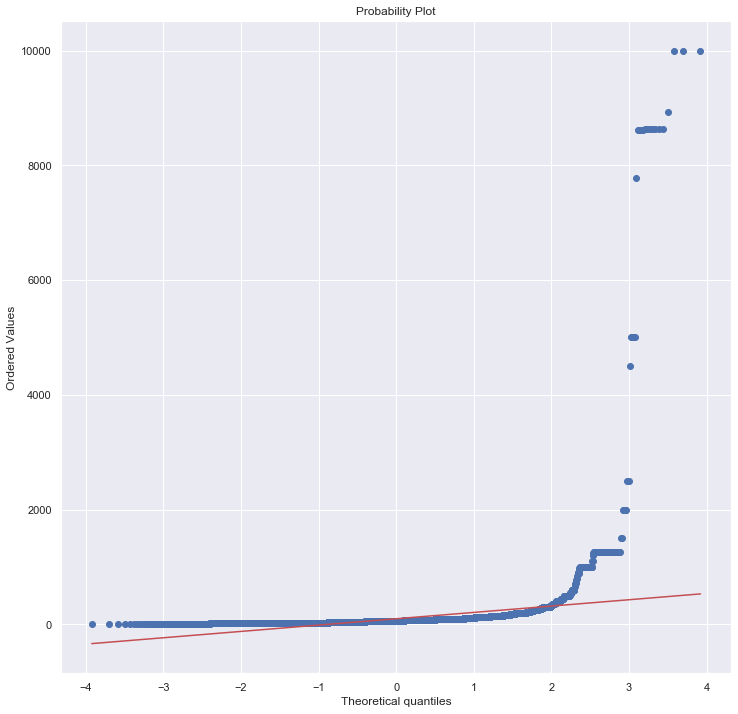

In [39]:
import pylab
import scipy.stats as stats
plt.figure(figsize=(12,12))
stats.probplot(just_p_v, dist="norm", plot=pylab)
pylab.show()

Main problem is that there are extreme values in the which corrupts the analysis. For example in the boxplot, it is so clear that, there are so extreme values in the upper qurtiles. This affects our QQplot above. Becasue of the extreme values, qqplot isn't well printed as well. Histogram is skewed on the left side. For that reason, we can't tell clear explanation from the plots above.

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [40]:
window = Window.partitionBy(f.col('neighbourhood')).orderBy(f.col('Float Price').desc())
df_madrid.select(f.col('*'), f.row_number().over(window).alias('row_number')).where(f.col('row_number') <= 3).show()

+--------+-----------+------+-----------------+--------------------+-----------------+--------+---------+----------+
|      id|Float Price|  city|    neighbourhood|review_scores_rating|    property_type|latitude|longitude|row_number|
+--------+-----------+------+-----------------+--------------------+-----------------+--------+---------+----------+
|20223709|      480.0|Madrid|          Legazpi|                 100|        Apartment|40.39057| -3.68595|         1|
|33682757|      290.0|Madrid|          Legazpi|                 100|            House|40.38633|   -3.686|         2|
|34269758|       75.0|Madrid|          Legazpi|                  97|        Apartment|40.39039| -3.69092|         3|
|33148298|     2500.0|Madrid|             Goya|                 100|   Boutique hotel|  40.424| -3.67724|         1|
|27598602|      978.0|Madrid|             Goya|                  83|        Apartment|40.42618|  -3.6788|         2|
|32310159|      300.0|Madrid|             Goya|                 

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [41]:
madrid = df4.filter(f.col('city') == "Madrid") 
madrid = madrid.cache()# store small database in memory
madrid.show(n=5)
madrid.printSchema()

+-----+------+-----------------+------------+-----------+-------------+
|   id|  city|number_of_reviews|first_review|last_review|neighbourhood|
+-----+------+-----------------+------------+-----------+-------------+
| 6369|Madrid|               65|  2010-03-14| 2019-09-04|   ChamartÃ­n|
|21853|Madrid|               33|  2014-10-10| 2018-07-15|       Aluche|
|24805|Madrid|                2|  2014-11-29| 2017-07-03|    MalasaÃ±a|
|24836|Madrid|               64|  2011-06-02| 2019-07-07|     Justicia|
|26825|Madrid|              136|  2010-05-10| 2019-07-10|      Legazpi|
+-----+------+-----------------+------------+-----------+-------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- first_review: date (nullable = true)
 |-- last_review: date (nullable = true)
 |-- neighbourhood: string (nullable = true)



In [42]:
sp_columns = ('id', 'first_review', 'last_review', 'number_of_reviews')
madrid_1 = madrid.select(*sp_columns)
madrid_1 = madrid_1.cache()# store small database in memory
madrid_1.show()
madrid_1.printSchema()

+-----+------------+-----------+-----------------+
|   id|first_review|last_review|number_of_reviews|
+-----+------------+-----------+-----------------+
| 6369|  2010-03-14| 2019-09-04|               65|
|21853|  2014-10-10| 2018-07-15|               33|
|24805|  2014-11-29| 2017-07-03|                2|
|24836|  2011-06-02| 2019-07-07|               64|
|26825|  2010-05-10| 2019-07-10|              136|
|30320|  2010-07-06| 2019-07-09|              168|
|30959|  2015-05-12| 2017-05-30|                8|
|40916|  2010-11-01| 2019-07-07|               38|
|59923|  2011-09-26| 2018-12-09|               14|
|62423|  2018-05-10| 2019-07-29|               57|
|70059|  2011-02-23| 2019-09-16|               85|
|70310|  2011-05-03| 2019-05-19|               18|
|70315|  2013-06-04| 2016-06-01|                3|
|70316|  2015-06-28| 2019-01-02|                6|
|72150|  2011-02-13| 2019-09-09|               95|
|72955|  2014-09-23| 2019-06-24|               14|
|74352|  2017-07-15| 2019-08-04

In [43]:
madrid_1 = madrid_1.orderBy('first_review', 'last_review')
madrid_1 = madrid_1.withColumn("monthDifference", f.months_between(f.col("last_review"),f.col('first_review')).cast(IntegerType()))
madrid_1 = madrid_1.withColumn("number_per_month", (f.col('number_of_reviews') / f.col('monthDifference')).cast(FloatType()))
madrid_1.show()
madrid_1.printSchema()

+------+------------+-----------+-----------------+---------------+----------------+
|    id|first_review|last_review|number_of_reviews|monthDifference|number_per_month|
+------+------------+-----------+-----------------+---------------+----------------+
|  6369|  2010-03-14| 2019-09-04|               65|            113|      0.57522124|
| 26825|  2010-05-10| 2019-07-10|              136|            110|       1.2363636|
| 30320|  2010-07-06| 2019-07-09|              168|            108|       1.5555556|
| 40916|  2010-11-01| 2019-07-07|               38|            104|       0.3653846|
| 72150|  2011-02-13| 2019-09-09|               95|            102|       0.9313725|
| 70059|  2011-02-23| 2019-09-16|               85|            102|       0.8333333|
| 70310|  2011-05-03| 2019-05-19|               18|             96|          0.1875|
| 84719|  2011-05-07| 2019-06-16|              178|             97|       1.8350515|
| 93100|  2011-05-07| 2019-09-14|              594|            10

Above table is for showing number of reviews per month. At the column of "number_per_month", for each host in the city number of reviews per month is calculated. Then, at the below code, new dataframe is prepared to visualize the number of reviewers in the city.

In [44]:
madrid_id = madrid_1.select('id')
madrid_id = madrid_id.cache()

In [45]:
t_id = madrid_id.alias('t_id')
t_rev = df3.alias('t_rev')

inner_join = t_id.join(t_rev, t_id.id == t_rev.id)
inner_join.show()

+------+------+----------+-----------+
|    id|    id|      date|reviewer_id|
+------+------+----------+-----------+
|176826|176826|2012-07-31|    2672297|
|176826|176826|2012-09-06|    3040895|
|176826|176826|2012-10-11|    3306967|
|176826|176826|2012-12-31|    4002001|
|176826|176826|2015-06-01|   12091726|
|176826|176826|2015-06-14|   23676695|
|176826|176826|2015-06-21|     521322|
|176826|176826|2015-06-25|    1833685|
|176826|176826|2015-06-30|   36079968|
|176826|176826|2015-07-04|   30547121|
|176826|176826|2015-07-05|   35999755|
|176826|176826|2016-10-09|   30729333|
|176826|176826|2016-10-12|   98234327|
|176826|176826|2016-10-15|   47323897|
|176826|176826|2016-10-20|   54824552|
|176826|176826|2016-10-28|  100868656|
|176826|176826|2016-10-30|   98659442|
|176826|176826|2016-11-19|   97828630|
|176826|176826|2016-11-21|   16036206|
|176826|176826|2017-01-01|   80068326|
+------+------+----------+-----------+
only showing top 20 rows



In [46]:
inner_join = inner_join.cache()
inner_join.count()
inner_join = inner_join.orderBy('date')
inner_join = inner_join.drop('id')
inner_join.show(n=5)
inner_join.printSchema()

+----------+-----------+
|      date|reviewer_id|
+----------+-----------+
|2010-03-14|      84790|
|2010-03-23|      84338|
|2010-04-10|      98655|
|2010-04-21|     109871|
|2010-04-26|      98901|
+----------+-----------+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- reviewer_id: integer (nullable = true)



If a date is repeated, number of the same date is calculated with row_number function. Then, dataframe is sorted by the highest value of each date. Then duplicate dates are dropped. In that way, only the highest values for each date, which means the repetition number of each date, exists still. Then it is plotted as follows;

In [49]:
w2 = Window.partitionBy(inner_join.date).orderBy(inner_join.date)
res = inner_join.withColumn('Number of Reviewer',f.row_number().over(w2))
res = res.drop('reviewer_id')
res=res.orderBy("date",f.col("Number of Reviewer").desc())
res = res.cache()
res1 = res.dropDuplicates(["date"]).toPandas() # Duplicates in the dates are dropped, therefore only the highest number for each
                                               # row stays then it is saved to Pandas dataframe to plot.

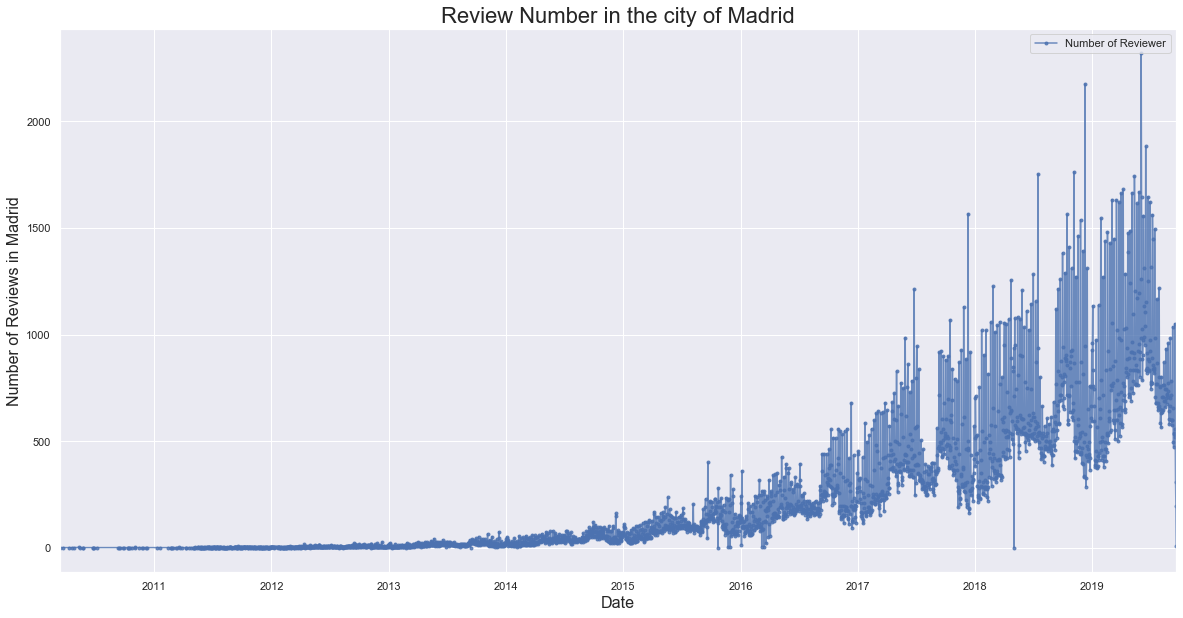

In [50]:
res1 = res1.set_index("date")
ax = res1.plot(marker = '.', figsize=(20, 10), alpha = 0.8,  linestyle='-') #  linestyle='None',
ax.set_ylabel('Number of Reviews in Madrid', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Review Number in the city of Madrid', fontsize=22)
plt.show()

As it can be seen above, there is a increase in the trend. At some seasons, there are sharp decreases which can be rooted by the winter season and the time just before the summer. This incline in trend may depend on two parameters. 1st parameter is that AirBnb penetration rate is increasing really fast. 2nd parameter is that, Madrid is visited more often year by year.

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison. 

In [51]:
sp_columns = ('id', 'neighbourhood')
madrid_2 = madrid.select(*sp_columns)
madrid_2 = madrid_2.cache()# store small database in memory
madrid_2.show()
madrid_2.printSchema()

+-----+-------------+
|   id|neighbourhood|
+-----+-------------+
| 6369|   ChamartÃ­n|
|21853|       Aluche|
|24805|    MalasaÃ±a|
|24836|     Justicia|
|26825|      Legazpi|
|30320|          Sol|
|30959|       Centro|
|40916|       Centro|
|59923|      Palacio|
|62423|       Centro|
|70059|       Centro|
|70310|       Centro|
|70315|      Palacio|
|70316|      Palacio|
|72150|  Embajadores|
|72955|       Centro|
|74352|       Centro|
|75609|  Embajadores|
|76617|    MalasaÃ±a|
|82481|    Recoletos|
+-----+-------------+
only showing top 20 rows

root
 |-- id: integer (nullable = true)
 |-- neighbourhood: string (nullable = true)



In [52]:
t1 = madrid_2.alias('t1')
t2 = df3.alias('t2')
inner2 = t1.join(t2, t1.id == t2.id)
inner2 = inner2.cache()
inner2.show()
inner2.count()

+----+-------------+----+----------+-----------+
|  id|neighbourhood|  id|      date|reviewer_id|
+----+-------------+----+----------+-----------+
|6369|   ChamartÃ­n|6369|2010-03-14|      84790|
|6369|   ChamartÃ­n|6369|2010-03-23|      84338|
|6369|   ChamartÃ­n|6369|2010-04-10|      98655|
|6369|   ChamartÃ­n|6369|2010-04-21|     109871|
|6369|   ChamartÃ­n|6369|2010-04-26|      98901|
|6369|   ChamartÃ­n|6369|2010-05-10|      95579|
|6369|   ChamartÃ­n|6369|2010-05-15|     106586|
|6369|   ChamartÃ­n|6369|2010-05-23|     112662|
|6369|   ChamartÃ­n|6369|2010-05-24|      18688|
|6369|   ChamartÃ­n|6369|2010-06-25|     134713|
|6369|   ChamartÃ­n|6369|2010-06-28|     103204|
|6369|   ChamartÃ­n|6369|2010-09-09|     142487|
|6369|   ChamartÃ­n|6369|2010-09-12|     105946|
|6369|   ChamartÃ­n|6369|2010-09-15|     212797|
|6369|   ChamartÃ­n|6369|2010-09-27|      51776|
|6369|   ChamartÃ­n|6369|2010-10-10|     159607|
|6369|   ChamartÃ­n|6369|2010-10-14|     184176|
|6369|   ChamartÃ­n|

729107

In [53]:
inner2.printSchema()

root
 |-- id: integer (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- reviewer_id: integer (nullable = true)



In [54]:
result2 = inner2.groupBy('neighbourhood').agg(f.countDistinct('reviewer_id'))
result2 = result2.orderBy(f.col('count(DISTINCT reviewer_id)').desc())
result2 = result2.cache()
result2.show(n=5)

+-------------+---------------------------+
|neighbourhood|count(DISTINCT reviewer_id)|
+-------------+---------------------------+
|       Centro|                     259210|
|  Embajadores|                      58973|
|          Sol|                      34088|
|    MalasaÃ±a|                      28675|
|    La Latina|                      24739|
+-------------+---------------------------+
only showing top 5 rows



In [55]:
inner2 = inner2.orderBy('neighbourhood', 'date')
inner2 = inner2.drop('id', 'reviewer_id')

Same logic like previous question is applied. If same date and same neighbourhood is repeated, number of the same date and same neighbourhood is calculated with row_number function. Then, dataframe is sorted by the highest value of neigbourhood then by each date. Then duplicate dates are dropped. In that way, only the number of repetition of each date is staying. Then it is plotted as follows;

In [56]:
column_list = ["date","neighbourhood"]

w3 = Window.partitionBy([f.col(x) for x in column_list]).orderBy(inner2.neighbourhood)
df = inner2.withColumn('Number of Reviewer',f.row_number().over(w3))
df = df.cache()
df = df.orderBy('neighbourhood','date', f.col("Number of Reviewer").desc())
df.show()

+-------------+----------+------------------+
|neighbourhood|      date|Number of Reviewer|
+-------------+----------+------------------+
|      Acacias|2014-06-14|                 1|
|      Acacias|2014-06-27|                 1|
|      Acacias|2014-07-12|                 1|
|      Acacias|2014-07-15|                 1|
|      Acacias|2014-07-29|                 1|
|      Acacias|2014-08-02|                 1|
|      Acacias|2014-08-15|                 1|
|      Acacias|2014-09-04|                 1|
|      Acacias|2014-09-06|                 1|
|      Acacias|2014-09-09|                 1|
|      Acacias|2014-09-12|                 1|
|      Acacias|2014-09-16|                 1|
|      Acacias|2014-09-19|                 1|
|      Acacias|2014-09-28|                 1|
|      Acacias|2014-09-30|                 1|
|      Acacias|2014-10-14|                 1|
|      Acacias|2014-10-24|                 1|
|      Acacias|2014-11-04|                 1|
|      Acacias|2014-11-23|        

In [57]:
df12 = df.dropDuplicates(["date"]).toPandas()
df12 = df12.sort_values(['neighbourhood', 'date'])
df12 = df12.set_index("date")
df12.tail(5)

,neighbourhood,Number of Reviewer
date,,
2011-08-07,Villaverde,1
2011-09-19,Villaverde,1
2011-10-20,Villaverde,1
2011-10-27,Villaverde,1
2012-01-27,Villaverde,1


In [58]:
print(df12.loc[df12.neighbourhood == 'Centro'].count(), "\n",df12.loc[df12.neighbourhood == 'Embajadores'].count(), "\n", df12.loc[df12.neighbourhood == 'Sol'].count())

neighbourhood         553
Number of Reviewer    553
dtype: int64 
 neighbourhood         51
Number of Reviewer    51
dtype: int64 
 neighbourhood         11
Number of Reviewer    11
dtype: int64


We have selected 3 different neighbourhood to visualize our data. Centro has most reviews at the number of 553. Embajadores has the second most reviews at the number of 51. Sol has the third most reviews at the number of 11.

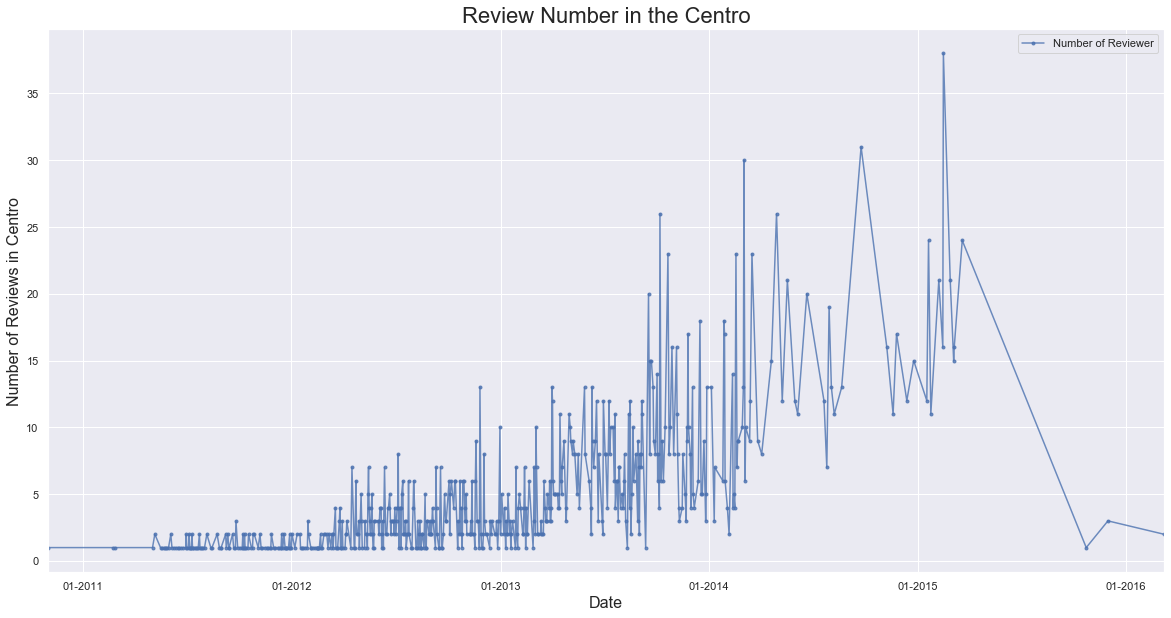

In [59]:
months = mdates.MonthLocator()  # every month
ax = df12.loc[df12.neighbourhood == 'Centro'].plot(marker = '.', figsize=(20, 10), alpha = 0.8) #  linestyle='None',
ax.set_ylabel('Number of Reviews in Centro', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Review Number in the Centro', fontsize=22)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'));

plt.show()

It is easy to see that, since there isn't a great famous winter holidays in Madris, in winter review number drops. But the trend is increasing. This incline in trend may depend on two parameters. 1st parameter is that AirBnb penetration rate is increasing really fast. 2nd parameter is that, Centro is visited more often year by year.

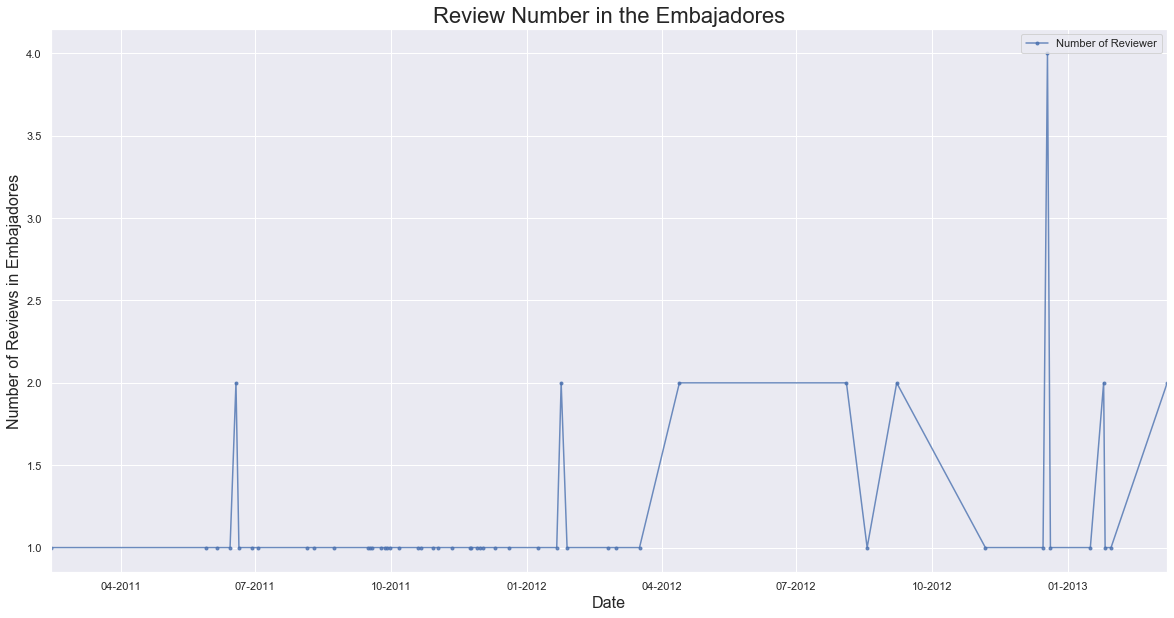

In [60]:
ax = df12.loc[df12.neighbourhood == 'Embajadores'].plot(marker = '.', figsize=(20, 10), alpha = 0.8) #  linestyle='None',
ax.set_ylabel('Number of Reviews in Embajadores', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Review Number in the Embajadores', fontsize=22)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'));

plt.show()

When the y axis is checked, maximum number is 4.0 Therefore It isn't so valid to comment since this sampling isn't a good enough sampling. 

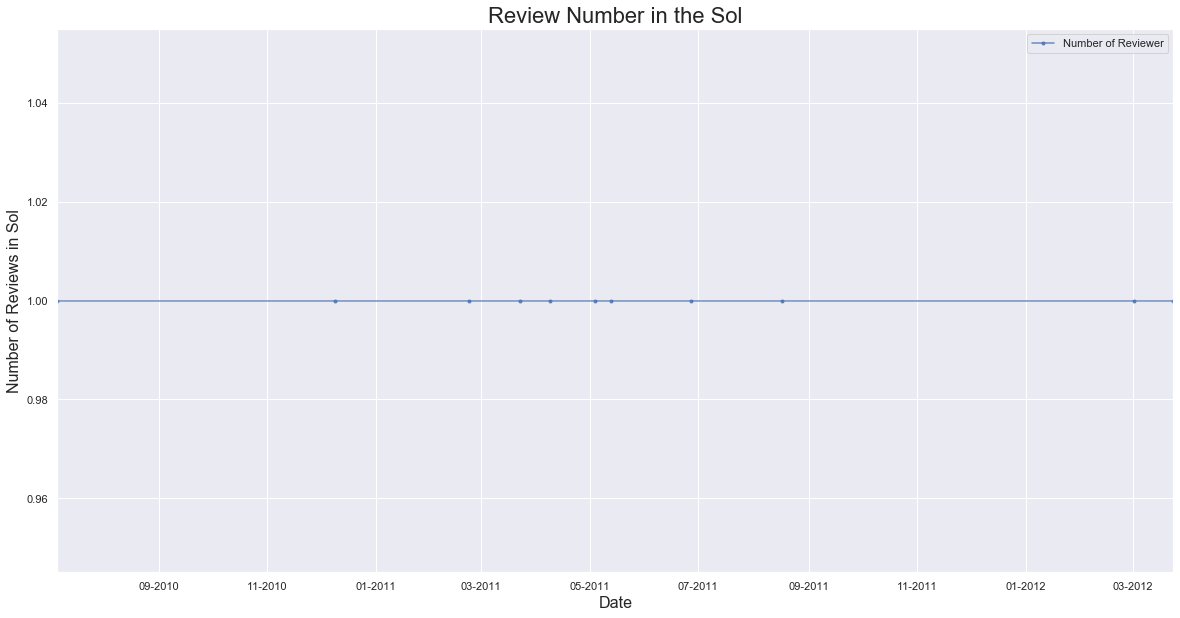

In [61]:
months = mdates.MonthLocator()  # every month
ax = df12.loc[df12.neighbourhood == 'Sol'].plot(marker = '.', figsize=(20, 10), alpha = 0.8) #  linestyle='None',
ax.set_ylabel('Number of Reviews in Sol', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Review Number in the Sol', fontsize=22)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'));

plt.show()

When the y axis is checked, maximum number is 1.0 Therefore It isn't so valid to comment since this sampling isn't a good enough sampling. Since we aren't summing into a windows like week or month, it seems that there isn't much people visiting there. But actually people are visiting but, we don't sum the values, we just show the values for each day.

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [62]:
res1 = res1.reset_index()
res2 = spark.createDataFrame(res1)
res2 = res2.withColumn("Number of Reviewer", res2["Number of Reviewer"].cast(IntegerType()))
res2 = res2.withColumn("date", f.trunc("date", "month"))
res2.show()
res2.printSchema()

+----------+------------------+
|      date|Number of Reviewer|
+----------+------------------+
|2010-03-01|                 1|
|2010-03-01|                 1|
|2010-04-01|                 1|
|2010-04-01|                 1|
|2010-04-01|                 1|
|2010-05-01|                 2|
|2010-05-01|                 1|
|2010-05-01|                 1|
|2010-05-01|                 1|
|2010-06-01|                 1|
|2010-06-01|                 1|
|2010-06-01|                 1|
|2010-07-01|                 1|
|2010-09-01|                 1|
|2010-09-01|                 1|
|2010-09-01|                 1|
|2010-09-01|                 1|
|2010-09-01|                 1|
|2010-10-01|                 1|
|2010-10-01|                 1|
+----------+------------------+
only showing top 20 rows

root
 |-- date: date (nullable = true)
 |-- Number of Reviewer: integer (nullable = true)



In this dataframe, we truncated the day values to sum the number of viewers easily. We created a dataframe which has year and month values and as a day values there is only "01" value. Then we summed number of reviewer for each date. Then it is plotted as follows;

In [63]:
res3 = res2.groupBy('date').agg(f.sum(f.col('Number of Reviewer')))
res3 = res3.orderBy('date')
res4 = res3.toPandas()
res4 = res4.set_index("date")
res4 = res4.rename(columns={"sum(Number of Reviewer)": "Number of Reviewer"})
res4.tail(10)

,Number of Reviewer
date,
2018-12-01,19701
2019-01-01,19428
2019-02-01,19161
2019-03-01,26264
2019-04-01,27462
2019-05-01,30990
2019-06-01,33906
2019-07-01,27414
2019-08-01,21974


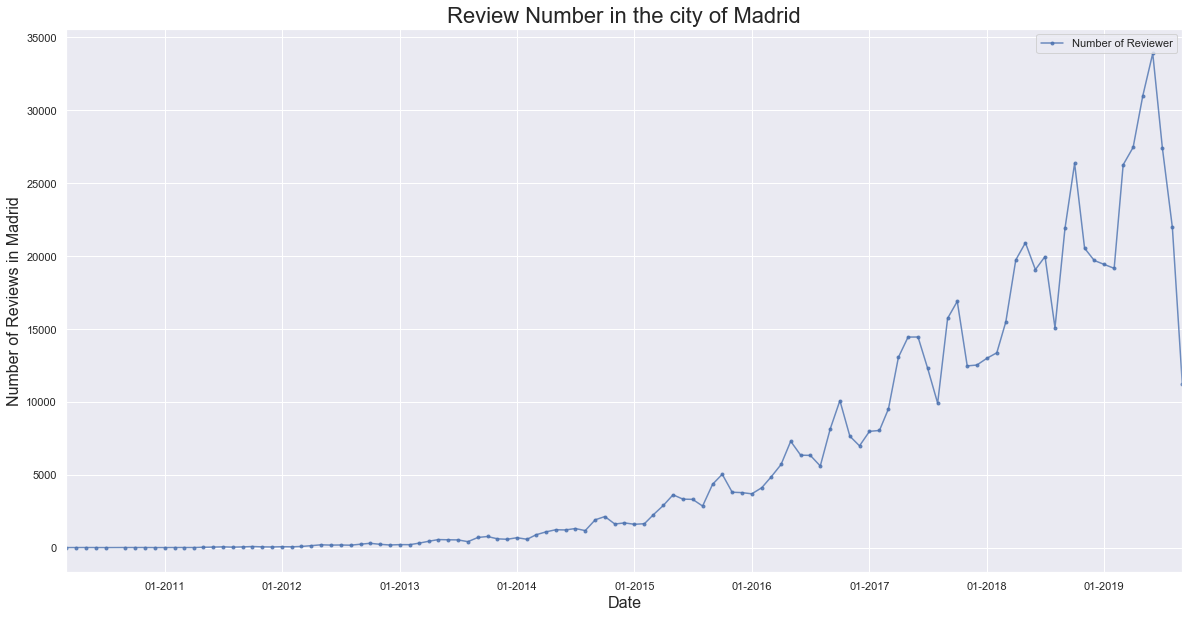

In [64]:
ax = res4.plot(marker = '.', figsize=(20, 10), alpha = 0.8) #  linestyle='None',
ax.set_ylabel('Number of Reviews in Madrid', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Review Number in the city of Madrid', fontsize=22)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'));

plt.show()

As we can see from the above plot, around in Eastern Break and in Summer number of reviews increases. In the winter and between eastern break and summer number of reviews decreases. But general trend is increasing. This can be because of city Madrid popularity is increasing or AirBnb's or both. 

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In [65]:
df2_ = df2.alias('df2_')
df1_ = df1.alias('df1_')

df2__ = df2_.join(df1_.select("id", "review_scores_rating"), "id")
df2__.show()

+------+--------------------+--------------------+
|    id|            comments|review_scores_rating|
+------+--------------------+--------------------+
|145320|Prima plek om Sto...|                  97|
|145320|Cosy and clean fl...|                  97|
|145320|The host canceled...|                  97|
|145320|Kim's place was o...|                  97|
|145320|great spacious ap...|                  97|
|145320|Kim is a very fri...|                  97|
|145320|The apartment is ...|                  97|
|145320|Nicely appointed,...|                  97|
|145320|It was a pleasure...|                  97|
|145320|Kim's place is si...|                  97|
|145320|We absolutely lov...|                  97|
|145320|Amazing place to ...|                  97|
|145320|Very pleasant sta...|                  97|
|145320|We had a wonderfu...|                  97|
|145320|Great location! C...|                  97|
|145320|Lovely flat in a ...|                  97|
|145320|Kimâ€™s flat is i...|  

In [66]:
reviews = df2__.select(f.concat(f.col("comments"), f.lit(" "), f.col("review_scores_rating")).alias("Merged-Columns"))
reviews.show()

+--------------------+
|      Merged-Columns|
+--------------------+
|Prima plek om Sto...|
|Cosy and clean fl...|
|The host canceled...|
|Kim's place was o...|
|great spacious ap...|
|Kim is a very fri...|
|The apartment is ...|
|Nicely appointed,...|
|It was a pleasure...|
|Kim's place is si...|
|We absolutely lov...|
|Amazing place to ...|
|Very pleasant sta...|
|We had a wonderfu...|
|Great location! C...|
|Lovely flat in a ...|
|Kimâ€™s flat is i...|
|I would definitel...|
|Kim's place is pe...|
|The flat is so co...|
+--------------------+
only showing top 20 rows



In [67]:
def step1 (x):
    x = x.split(" ")
    resul = []
    for i in x [:len(x) - 1]:
        resul.append ((i, (1, int(x[len(x) - 1]))))
    
    return resul      

In [68]:
rdd = reviews.rdd.map(list).map(lambda lis : lis[0]).flatMap(step1)\
            .reduceByKey(lambda a, b : (a[0] + b[0], a[1] + b[1]))\
            .filter(lambda x: x[1][0] > 10000)\
            .map(lambda x: (x[0], x[1][1]/x[1][0]))\
            .sortBy(lambda x: x[1],ascending = False)

In [73]:
rdd = rdd.cache()

In [74]:
rdd.take(20)

[('Alberta', 97.77291086976034),
 ('Portland!', 97.66885173455108),
 ('Portland', 97.5464342999261),
 ('Portland.', 97.53717088280847),
 ('Austin!', 97.46103089582363),
 ('Denver', 97.45495927168184),
 ('Denver.', 97.44653173511496),
 ('immaculate,', 97.39214300854943),
 ('snacks,', 97.35978999382334),
 ('Austin.', 97.34650284481067),
 ('Magazine', 97.30225988700565),
 ('homemade', 97.27062285434036),
 ('touches,', 97.24391405840598),
 ('cottage', 97.23650067294751),
 ('thoughtfully', 97.18264606876653),
 ('immaculate', 97.17867217830909),
 ('touches', 97.17618136983543),
 ('goodies', 97.17046229374063),
 ('cottage.', 97.16282894736842),
 ('impeccably', 97.1329764144118)]

Each word has the weight of its corresponding review rating. We calculate the times a word appears and the sum of the weights. In the next step we use both to compute the averege of each word. Then 20 words which has the highest rate are printed above. We filtered words which appears more then 10000 times as it is required in the problem statement as well.